In [1]:
# libraries used
import boto3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
import os
from diff_predictor import core, data_process, predxgboost, spatial

#from diff_predictor import spatial
from matplotlib import colors as plt_colors

#import altair as alt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn import preprocessing

import xgboost as xgb


import shap

Using current directory for loading/saving: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
To change current directory, call diff_predictor.core.change_dir(...)


In [2]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [4]:
dataset_path = workbookDir + '/data/raw_data_age/'
#msd_path = workbookDir + '/nlsschim/raw_data_pnn/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f)) and 'feat' in f]
#msd_filelist = [f for f in listdir(msd_path) if isfile(join(msd_path, f)) and 'msd' in f]
#print(len(msd_filelist))
print(len(filelist))

75


In [93]:
# output_path = workbookDir + '/Users/nlsschim/features_ecm/'
# feat_filelist = [f for f in listdir(output_path) if isfile(join(output_path, f)) and 'features' in f]
# len(feat_filelist)

In [94]:
# remaining_msd = msd_filelist[58:]
# remaining_msd

In [95]:
# msd_df = pd.read_csv(msd_path + str(msd_filelist[0]))
# msd_df.head()

In [96]:
# for file in remaining_msd:
#     msd_df = pd.read_csv(msd_path+str(file))
#     print('starting: ' + file)
#     fea_df = calculate_features(msd_df, mean_values=True)
#     path = workbookDir
#     fname = 'features' + file[3:]
#     full_str = path + '/nlsschim/features_ecm/' + fname
#     fea_df.to_csv(full_str)
#     print(full_str)
#     print('')

In [5]:
fstats_tot = data_process.generate_fullstats(dataset_path, filelist, ['P14', 'P70'], 'Age')

Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file features_P70_40nm_s1_v1.csv size: (27, 67)
Adding file features_P70_40nm_s3_v4.csv size: (2909, 67)
Adding file features_P14_40nm_s1_v1.csv size: (793, 91)
Adding file features_P14_40nm_s1_v3.csv size: (519, 91)
Adding file features_P70_40nm_s1_v3.csv size: 

In [5]:
fstats_tot.columns

Index(['AR', 'D_fit', 'Deff1', 'Deff2', 'MSD_ratio', 'Mean AR', 'Mean D_fit',
       'Mean Deff1', 'Mean Deff2', 'Mean MSD_ratio', 'Mean Mean_Intensity',
       'Mean Quality', 'Mean SN_Ratio', 'Mean X', 'Mean Y', 'Mean alpha',
       'Mean asymmetry1', 'Mean asymmetry2', 'Mean asymmetry3',
       'Mean boundedness', 'Mean efficiency', 'Mean elongation',
       'Mean fractal_dim', 'Mean frames', 'Mean kurtosis', 'Mean straightness',
       'Mean trappedness', 'Mean_Intensity', 'Quality', 'SN_Ratio', 'Std AR',
       'Std D_fit', 'Std Deff1', 'Std Deff2', 'Std MSD_ratio',
       'Std Mean_Intensity', 'Std Quality', 'Std SN_Ratio', 'Std X', 'Std Y',
       'Std alpha', 'Std asymmetry1', 'Std asymmetry2', 'Std asymmetry3',
       'Std boundedness', 'Std efficiency', 'Std elongation',
       'Std fractal_dim', 'Std frames', 'Std kurtosis', 'Std straightness',
       'Std trappedness', 'Track_ID', 'Treatment', 'Video Number', 'X', 'Y',
       'alpha', 'asymmetry1', 'asymmetry2', 'asymmetry3

In [6]:
fstats_tot.shape

(215893, 69)

In [18]:
dropped_fstats = fstats_tot.drop_duplicates(['Mean Deff1', 'Mean D_fit'])
dropped_fstats.shape

(3389, 93)

In [7]:
fstats_tot[columns].isnull().sum()/len(fstats_tot)


NameError: name 'columns' is not defined

In [19]:
# The column Deff2 currently has a super high number (~97%) of null values, so might be worth not including
# As such, it is commented out below
columns = [
#     'alpha', # Fitted anomalous diffusion alpha exponenet
#     'D_fit', # Fitted anomalous diffusion coefficient
#     'kurtosis', # Kurtosis of track
#     'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
#     'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
#     'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
#     'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
#     'elongation', # Est. of amount of extension of trajectory from centroid
#     'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
#     'fractal_dim', # Measure of how complicated a self similar figure is
#     'trappedness', # Probability that a particle with Deff is trapped in a region
#     'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
#     'straightness', # Ratio of net displacement to the sum of squared step lengths
#     'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
#     'Deff1', # Effective diffusion coefficient at 0.33 s
#     'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha',
    'Mean D_fit',
    'Mean kurtosis',
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3',
    'Mean AR',
    'Mean elongation',
    'Mean boundedness',
    'Mean fractal_dim',
    'Mean trappedness',
    'Mean efficiency',
    'Mean straightness',
    'Mean MSD_ratio',
    'Mean Deff1',
    #'Mean Deff2',
    'X',
    'Y',
    'Age'
]

target = 'Age'

ecm = dropped_fstats[columns]#.drop(['Deff2', 'Mean Deff2', 'Std Deff2'], axis=1) # Removing since 97% is null
#ecm['Treatment'] = fstats_tot['Treatment'].values
#ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)] # removes rows with nan or inf points
ecm = ecm[~ecm[list(set(columns) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points


In [20]:
ecm.shape

(3134, 18)

In [21]:
bal_ecm = data_process.balance_data(ecm, target, random_state=1)
bal_ecm = data_process.bin_data(bal_ecm, resolution=128)

Ratio before data balance (P70:P14) = 1457:1677
Ratio after balance (P70:P14) = 1457:1457


In [12]:
bal_ecm.shape

(16628, 22)

In [13]:
label_df = bal_ecm['Treatment']
features_df = bal_ecm.drop(['Treatment', 'X', 'Y', 'binx', 'biny', 'bins'], axis=1)

In [14]:
# Create list of features for training
features = features_df.columns

In [15]:
bal_ecm.tail()

,Mean alpha,Mean D_fit,Mean kurtosis,Mean asymmetry1,Mean asymmetry2,Mean asymmetry3,Mean AR,Mean elongation,Mean boundedness,Mean fractal_dim,...,Mean straightness,Mean MSD_ratio,Mean Deff1,Mean Deff2,X,Y,Treatment,binx,biny,bins
167020,1.112462,26.058785,2.989111,0.881306,0.162757,0.326707,3.023821,0.591069,0.095776,1.553677,...,0.329832,0.362039,12.383219,5.005047,303.271674,1109.270945,NT,2,8,40
210086,1.191272,19.920654,2.000902,0.859462,0.170287,0.335300,2.450203,0.530278,0.065074,1.442278,...,0.350424,-0.020939,23.185977,21.181557,240.752048,778.482496,NT,1,6,22
153017,1.402974,30.007699,2.363679,0.803347,0.217855,0.264639,2.248427,0.522247,0.094904,1.499625,...,0.306984,0.484490,29.919967,19.577469,1615.865619,1180.583766,NT,12,9,201
188547,0.591190,16.287215,3.352516,0.743162,0.253763,0.281439,2.306327,0.461332,0.100437,1.963085,...,0.116395,1.246721,4.594630,4.162652,863.514978,818.669390,NT,6,6,102
147788,0.387420,30.374553,3.031603,0.871607,0.175020,0.300266,1.657292,0.300476,0.046445,1.787998,...,0.073644,0.225101,3.964897,3.691171,945.087572,1065.856554,NT,7,8,120


In [16]:
result, le = spatial.split_data(bal_ecm, target, 0.5, 0.5)

In [17]:
result[4]

,Mean alpha,Mean D_fit,Mean kurtosis,Mean asymmetry1,Mean asymmetry2,Mean asymmetry3,Mean AR,Mean elongation,Mean boundedness,Mean fractal_dim,...,Mean MSD_ratio,Mean Deff1,Mean Deff2,X,Y,Treatment,binx,biny,bins,encoded_target
55414,0.551459,23.849415,2.730867,0.577601,0.378310,0.148722,1.753147,0.397714,0.079250,1.706536,...,0.286519,7.237469,6.584330,837.515968,1711.303212,ChABC,6,13,109,0
157230,0.160070,48.609407,1.562731,0.540229,0.381621,0.318224,2.504769,0.475606,0.057397,1.917708,...,1.192111,5.952656,5.787417,396.096791,442.078954,NT,3,3,51,1
40732,0.497854,19.609579,3.434146,0.770335,0.233625,0.271632,2.347181,0.490918,0.134767,1.676478,...,3.770473,7.220482,5.976220,905.764160,855.168352,ChABC,7,6,118,0
45023,0.638370,17.116219,2.644558,0.520974,0.399371,0.175183,1.841962,0.306368,0.121248,1.944522,...,0.370932,8.343530,4.446003,707.847422,614.382116,ChABC,5,4,84,0
214335,0.318987,7.451233,3.591340,0.706929,0.267792,0.272358,2.384425,0.445786,0.116698,2.042929,...,1.020226,1.247882,0.989498,1034.486750,1733.135046,NT,8,13,141,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210675,0.171764,6.791712,2.891439,0.988305,0.046727,0.542810,3.066728,0.664297,0.070590,2.048735,...,1.136776,1.325676,0.873839,339.247976,1527.165444,NT,2,11,43,1
26184,1.164995,36.505176,2.388270,0.898965,0.143294,0.362634,2.411789,0.512439,0.091489,1.480716,...,0.114011,38.929585,44.336929,463.670235,1747.035296,ChABC,3,13,61,0
186695,0.996641,7.349058,2.788789,0.788370,0.225737,0.262888,2.179449,0.473329,0.103213,1.988430,...,0.413043,2.037713,2.508305,267.794649,1846.117299,NT,2,14,46,1
200679,0.129140,20.189574,1.824587,0.769628,0.255673,0.193208,1.695584,0.410233,0.124874,2.432070,...,0.512493,2.712765,1.931627,664.007008,1033.912527,NT,5,8,88,1


In [18]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

# dtrain = X_train[features]
# dtest = X_test[features]
# dval = X_val[features]

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
dval = xgb.DMatrix(X_val[features], label=y_val)

In [19]:
#Check lengths of datasets:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(bal_ecm):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(bal_ecm):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(bal_ecm):.3f}%)')
    except:
        pass
get_lengths(bal_ecm, X_train, X_test, X_val)

Tot before split: 16628
Training: 8350 (0.502%)
Testing: 4139 (0.249%)
Evaluation: 4139 (0.249%)


In [103]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 2,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
         #GPU integration will cut time in ~half:
         'gpu_id' : 0,
         'tree_method': 'gpu_hist',
         'predictor': 'gpu_predictor'
         }

best_boost_rounds = 477

In [104]:
model = xgb.XGBClassifier()

In [1]:
def train(param, dtrain, dtest, dval=None, evals=[(dtrain, 'train')], num_round=40):
    if dval is not None and (dval, 'eval') not in evals:
        evals += [(dval, 'eval')]
    model = xgb.train(param, dtrain, num_round, evals, )
    true_label = dtest.get_label()
    ypred = model.predict(dtest)
    preds = [np.where(x == np.max(x))[0][0] for x in ypred]
    acc = metrics.accuracy_score(true_label, preds)
    print("Accuracy:",acc)
    return model, acc, true_label, preds
booster, acc, true_label, preds = train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=best_boost_rounds)

NameError: name 'dtrain' is not defined

In [16]:
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException

def cv(params, X_train, y_train, features=None, num_boost_round=20, nfold=3, stratified=False, folds=None,
       metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None,
       fpreproc=None, as_pandas=True, verbose_eval=100, show_stdv=True,
       seed=0, callbacks=None, shuffle=True):
    # pylint: disable = invalid-name
    """Cross-validation with given parameters.

    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round : int
        Number of boosting iterations.
    nfold : int
        Number of folds in CV.
    stratified : bool
        Perform stratified sampling.
    folds : a KFold or StratifiedKFold instance or list of fold indices
        Sklearn KFolds or StratifiedKFolds object.
        Alternatively may explicitly pass sample indices for each fold.
        For ``n`` folds, **folds** should be a length ``n`` list of tuples.
        Each tuple is ``(in,out)`` where ``in`` is a list of indices to be used
        as the training samples for the ``n`` th fold and ``out`` is a list of
        indices to be used as the testing samples for the ``n`` th fold.
    metrics : string or list of strings
        Evaluation metrics to be watched in CV.
    obj : function
        Custom objective function.
    feval : function
        Custom evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Cross-Validation metric (average of validation
        metric computed over CV folds) needs to improve at least once in
        every **early_stopping_rounds** round(s) to continue training.
        The last entry in the evaluation history will represent the best iteration.
        If there's more than one metric in the **eval_metric** parameter given in
        **params**, the last metric will be used for early stopping.
    fpreproc : function
        Preprocessing function that takes (dtrain, dtest, param) and returns
        transformed versions of those.
    as_pandas : bool, default True
        Return pd.DataFrame when pandas is installed.
        If False or pandas is not installed, return np.ndarray
    verbose_eval : bool, int, or None, default None
        Whether to display the progress. If None, progress will be displayed
        when np.ndarray is returned. If True, progress will be displayed at
        boosting stage. If an integer is given, progress will be displayed
        at every given `verbose_eval` boosting stage.
    show_stdv : bool, default True
        Whether to display the standard deviation in progress.
        Results are not affected, and always contains std.
    seed : int
        Seed used to generate the folds (passed to numpy.random.seed).
    callbacks : list of callback functions
        List of callback functions that are applied at end of each iteration.
        It is possible to use predefined callbacks by using
        :ref:`Callback API <callback_api>`.
        Example:

        .. code-block:: python

            [xgb.callback.reset_learning_rate(custom_rates)]
    shuffle : bool
        Shuffle data before creating folds.

    Returns
    -------
    evaluation history : list(string)
    """
    if stratified is True and not SKLEARN_INSTALLED:
        raise XGBoostError('sklearn needs to be installed in order to use stratified cv')
    if isinstance(metrics, str):
        metrics = [metrics]
    #if features == None:
        #features = X_train.columns
    if isinstance(params, list):
        _metrics = [x[1] for x in params if x[0] == 'eval_metric']
        params = dict(params)
        if 'eval_metric' in params:
            params['eval_metric'] = _metrics
    else:
        params = dict((k, v) for k, v in params.items())
    if (not metrics) and 'eval_metric' in params:
        if isinstance(params['eval_metric'], list):
            metrics = params['eval_metric']
        else:
            metrics = [params['eval_metric']]
    params.pop("eval_metric", None)
    results = {}
    # create folds in data
    cvfolds, wt_list = mknfold(X_train, y_train, nfold, params, metrics, features)
    
    # setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=False))
    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    elif isinstance(verbose_eval, int):
        callbacks.append(callback.print_evaluation(verbose_eval, show_stdv=show_stdv))
    callbacks_before_iter = [
        cb for cb in callbacks if
        cb.__dict__.get('before_iteration', False)]
    callbacks_after_iter = [
        cb for cb in callbacks if
        not cb.__dict__.get('before_iteration', False)]
    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=cvfolds,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in cvfolds:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in cvfolds], wt_list)
        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=cvfolds,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results:
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return results

In [17]:
def bin_fold(X_train, nfold):
    bin_list = [X_train[X_train['bins'] == i_bin].index.to_numpy() for i_bin in X_train.bins.unique()]
    bin_list = sorted(bin_list, key=len)
    i = 0
    while(len(bin_list) > nfold):
        if (i >= len(bin_list)-1):
            i = 0
        bin_list[i] = np.concatenate([bin_list[i], bin_list.pop()])
        i += 1
    wt_list = [len(i)/sum(len(s) for s in bin_list) for i in bin_list]
    return bin_list, wt_list

def mknfold(X_train, y_train, nfold, param, evals=(), features=None):
    #if not features:
        #features = X_train.columns
    dall = xgb.DMatrix(X_train[features], label=y_train)
    out_idset, wt_list = bin_fold(X_train, nfold)
    in_idset = [np.concatenate([out_idset[i] for i in range(nfold) if k != i]) for k in range(nfold)]
    evals = list(evals)
    ret = []
    for k in range(nfold):
        # perform the slicing using the indexes determined by the above methods
        x_train_snip = X_train.loc[in_idset[k]][features]
        y_train_snip = X_train.loc[in_idset[k]]['encoded_target']        
        x_test_snip = X_train.loc[out_idset[k]][features]
        y_test_snip = X_train.loc[out_idset[k]]['encoded_target']
        dtrain = xgb.DMatrix(x_train_snip, label=y_train_snip)
        dtest = xgb.DMatrix(x_test_snip, label=y_test_snip)
        tparam = param
        plst = list(tparam.items()) + [('eval_metric', itm) for itm in evals]
        ret.append(CVPack(dtrain, dtest, plst))
    return ret, wt_list

In [18]:
from xgboost.core import STRING_TYPES

def aggcv(rlist, wt_list):
    # pylint: disable=invalid-name
    """
    Aggregate cross-validation results.

    If verbose_eval is true, progress is displayed in every call. If
    verbose_eval is an integer, progress will only be displayed every
    `verbose_eval` trees, tracked via trial.
    """
    cvmap = {}
    idx = rlist[0].split()[0]
    for line in rlist:
        arr = line.split()
        assert idx == arr[0]
        for metric_idx, it in enumerate(arr[1:]):
            if not isinstance(it, STRING_TYPES):
                it = it.decode()
            k, v = it.split(':')
            if (metric_idx, k) not in cvmap:
                cvmap[(metric_idx, k)] = []
            cvmap[(metric_idx, k)].append(float(v))
    msg = idx
    results = []
    for (metric_idx, k), v in sorted(cvmap.items(), key=lambda x: x[0][0]):
        v = np.array(v)
        if not isinstance(msg, STRING_TYPES):
            msg = msg.decode()
        mean = np.average(v, weights=wt_list)
        std = np.average((v-mean)**2, weights=wt_list)
        results.extend([(k, mean, std)])
    return results

In [19]:
# cv_results = cv(param, X_train, y_train, features, num_boost_round=10, nfold=2, early_stopping_rounds=1, metrics={'mlogloss'})
# cv_results

In [20]:
import operator
import numpy as np

def xgb_paramsearch(X_train, y_train, features, init_params, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics=None, **kwargs):
    params = {**init_params}
    if 'use_gpu' in kwargs and kwargs['use_gpu']:
    #     # GPU integration will cut cv time in ~half:
        params.update({'gpu_id' : 0,
                      'tree_method': 'gpu_hist',
                       'predictor': 'gpu_predictor'})
    if 'metrics' not in kwargs:
        metrics = {params['eval_metric']}
    else:
        metrics.add(params['eval_metric'])
    if params['eval_metric'] in ['map', 'auc', 'aucpr']:
        eval_f = operator.gt
    else: 
        eval_f = operator.lt
    if 'early_break' not in kwargs:
        early_break = 5
    else: 
        early_break = kwargs['early_break']
    if 'thresh' not in kwargs:
        thresh = 0.01
    else: 
        thresh = kwargs['thresh']
    if 'seed' not in kwargs:
        seed = 1111
    else: 
        seed = kwargs['seed']
    best_param = params
    best_model = cv(params, 
                    X_train, 
                    y_train, 
                    features, 
                    nfold=nfold, 
                    num_boost_round=num_boost_round, 
                    early_stopping_rounds=early_stopping_rounds, 
                    metrics=metrics)
    best_eval = best_model[f"test-{params['eval_metric']}-mean"].min()
    best_boost_rounds = best_model[f"test-{params['eval_metric']}-mean"].idxmin()
    
    def _gs_helper(var1n, var2n, best_model, best_param, best_eval, best_boost_rounds):
        local_param = {**best_param}
        for var1, var2 in gs_params:
            print(f"Using CV with {var1n}={{{var1}}}, {var2n}={{{var2}}}")
            local_param[var1n] = var1
            local_param[var2n] = var2
            cv_model = cv(local_param, 
                          X_train, 
                          y_train, 
                          features, 
                          nfold = nfold, 
                          num_boost_round = num_boost_round, 
                          early_stopping_rounds = early_stopping_rounds, 
                          metrics = metrics)
            cv_eval = cv_model[f"test-{local_param['eval_metric']}-mean"].min()
            boost_rounds = cv_model[f"test-{local_param['eval_metric']}-mean"].idxmin()
            if(eval_f(cv_eval, best_eval)):
                best_model = cv_model
                best_param[var1n] = var1
                best_param[var2n] = var2
                best_eval = cv_eval
                best_boost_rounds = boost_rounds
                print(f"New best param found: "
                      f"{local_param['eval_metric']} = {{{best_eval}}}, "
                      f"boost_rounds = {{{best_boost_rounds}}}")
        return best_model, best_param, best_eval, best_boost_rounds
    
    while(early_break >= 0):
        np.random.seed(seed)
        best_eval_init = best_eval
        gs_params = {
            (subsample, colsample)
            for subsample in np.random.choice([i/10. for i in range(5,11)], 3)
            for colsample in np.random.choice([i/10. for i in range(5,11)], 3)
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('subsample', 
                                                                          'colsample_bytree', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (max_depth, min_child_weight)
            for max_depth in [10] + list(np.random.randint(1, 10, 3))
            for min_child_weight in [0, 10] + list(np.random.randint(0, 10, 3))
        }
        best_model, 
        best_param, 
        best_eval, 
        best_boost_rounds = _gs_helper('max_depth', 
                                                                          'min_child_weight', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        gs_params = {
            (eta, gamma)
            for eta in np.random.choice([.005, .01, .05, .1, .2, .3], 3)
            for gamma in [0] + list(np.random.choice([0.01, 0.001, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0], 3))
        }
        best_model, best_param, best_eval, best_boost_rounds = _gs_helper('eta', 
                                                                          'gamma', 
                                                                          best_model, 
                                                                          best_param, 
                                                                          best_eval, 
                                                                          best_boost_rounds)
        if (abs(best_eval_init - best_eval) < thresh):
            early_break-=1
        seed+=1
    return best_model, best_param, best_eval, best_boost_rounds

In [28]:
np.random.randint(1, 10, 5)

array([2, 6, 9, 5, 2])

In [29]:
(best_model, best_param, best_eval, best_boost_rounds) = xgb_paramsearch(X_train, 
                                                                         y_train, 
                                                                         features, 
                                                                         init_params=param, 
                                                                         nfold=5, 
                                                                         num_boost_round=2000, 
                                                                         early_stopping_rounds=3, 
                                                                         metrics={'merror', 'mlogloss'},
                                                                         use_gpu='True')
                                                                         
                                                                 
                                                                          
                                                                         
                                                                         
                                                                         

[0]	train-mlogloss:0.69245+0.00000	test-mlogloss:0.69245+0.00000
[100]	train-mlogloss:0.64814+0.00000	test-mlogloss:0.64968+0.00001
[200]	train-mlogloss:0.62883+0.00000	test-mlogloss:0.63149+0.00002
[300]	train-mlogloss:0.61935+0.00001	test-mlogloss:0.62293+0.00004
[400]	train-mlogloss:0.61448+0.00001	test-mlogloss:0.61878+0.00005
[500]	train-mlogloss:0.61189+0.00001	test-mlogloss:0.61673+0.00006
[600]	train-mlogloss:0.61041+0.00001	test-mlogloss:0.61562+0.00006
[700]	train-mlogloss:0.60937+0.00001	test-mlogloss:0.61495+0.00007
[800]	train-mlogloss:0.60858+0.00001	test-mlogloss:0.61444+0.00007
Using CV with subsample={0.9}, colsample_bytree={0.9}
[0]	train-mlogloss:0.69241+0.00000	test-mlogloss:0.69244+0.00000
[100]	train-mlogloss:0.64423+0.00000	test-mlogloss:0.64724+0.00001
[200]	train-mlogloss:0.62294+0.00000	test-mlogloss:0.62832+0.00003
[300]	train-mlogloss:0.61285+0.00000	test-mlogloss:0.62010+0.00004
[400]	train-mlogloss:0.60757+0.00001	test-mlogloss:0.61641+0.00005
[500]	train-

[600]	train-mlogloss:0.60068+0.00001	test-mlogloss:0.61321+0.00007
[700]	train-mlogloss:0.59976+0.00001	test-mlogloss:0.61280+0.00007
Using CV with max_depth={10}, min_child_weight={10}
[0]	train-mlogloss:0.69239+0.00000	test-mlogloss:0.69244+0.00000
[100]	train-mlogloss:0.64249+0.00000	test-mlogloss:0.64661+0.00001
[200]	train-mlogloss:0.62073+0.00000	test-mlogloss:0.62755+0.00003
[300]	train-mlogloss:0.61057+0.00001	test-mlogloss:0.61935+0.00004
[400]	train-mlogloss:0.60551+0.00001	test-mlogloss:0.61571+0.00005
[500]	train-mlogloss:0.60270+0.00001	test-mlogloss:0.61400+0.00006
[600]	train-mlogloss:0.60116+0.00001	test-mlogloss:0.61318+0.00007
[700]	train-mlogloss:0.60025+0.00001	test-mlogloss:0.61278+0.00007
New best param found: mlogloss = {0.6125274840718563}, boost_rounds = {793}
Using CV with max_depth={4}, min_child_weight={5}
[0]	train-mlogloss:0.69239+0.00000	test-mlogloss:0.69244+0.00000
[100]	train-mlogloss:0.64308+0.00000	test-mlogloss:0.64673+0.00001
[200]	train-mlogloss:0

[100]	train-mlogloss:0.62207+0.00000	test-mlogloss:0.64444+0.00001
[200]	train-mlogloss:0.58304+0.00000	test-mlogloss:0.62477+0.00003
[300]	train-mlogloss:0.55805+0.00000	test-mlogloss:0.61652+0.00005
[400]	train-mlogloss:0.54036+0.00000	test-mlogloss:0.61323+0.00006
Using CV with eta={0.005}, gamma={5.0}
[0]	train-mlogloss:0.69239+0.00000	test-mlogloss:0.69244+0.00000
[100]	train-mlogloss:0.64249+0.00000	test-mlogloss:0.64661+0.00001
[200]	train-mlogloss:0.62073+0.00000	test-mlogloss:0.62755+0.00003
[300]	train-mlogloss:0.61058+0.00001	test-mlogloss:0.61935+0.00004
[400]	train-mlogloss:0.60551+0.00001	test-mlogloss:0.61571+0.00005
[500]	train-mlogloss:0.60271+0.00001	test-mlogloss:0.61400+0.00006
[600]	train-mlogloss:0.60117+0.00001	test-mlogloss:0.61318+0.00007
[700]	train-mlogloss:0.60026+0.00001	test-mlogloss:0.61277+0.00007
Using CV with eta={0.3}, gamma={5.0}
[0]	train-mlogloss:0.65410+0.00000	test-mlogloss:0.65703+0.00000
Using CV with eta={0.05}, gamma={10.0}
[0]	train-mlogloss

Using CV with subsample={1.0}, colsample_bytree={0.7}
[0]	train-mlogloss:0.67798+0.00000	test-mlogloss:0.67935+0.00000
Using CV with max_depth={10}, min_child_weight={8}
[0]	train-mlogloss:0.67075+0.00000	test-mlogloss:0.67933+0.00000
Using CV with max_depth={9}, min_child_weight={0}
[0]	train-mlogloss:0.66590+0.00000	test-mlogloss:0.67905+0.00000
Using CV with max_depth={3}, min_child_weight={3}
[0]	train-mlogloss:0.67909+0.00000	test-mlogloss:0.67989+0.00000
Using CV with max_depth={9}, min_child_weight={1}
[0]	train-mlogloss:0.66635+0.00000	test-mlogloss:0.67906+0.00000
Using CV with max_depth={10}, min_child_weight={10}
[0]	train-mlogloss:0.67177+0.00000	test-mlogloss:0.67937+0.00000
Using CV with max_depth={10}, min_child_weight={7}
[0]	train-mlogloss:0.67014+0.00000	test-mlogloss:0.67931+0.00000
Using CV with max_depth={3}, min_child_weight={0}
[0]	train-mlogloss:0.67909+0.00000	test-mlogloss:0.67989+0.00000
Using CV with max_depth={3}, min_child_weight={10}
[0]	train-mlogloss:0.

[0]	train-mlogloss:0.66238+0.00000	test-mlogloss:0.67926+0.00000
Using CV with max_depth={10}, min_child_weight={3}
[0]	train-mlogloss:0.66633+0.00000	test-mlogloss:0.67965+0.00000
Using CV with max_depth={10}, min_child_weight={9}
[0]	train-mlogloss:0.67119+0.00000	test-mlogloss:0.67935+0.00000
Using CV with eta={0.2}, gamma={1.0}
[0]	train-mlogloss:0.66459+0.00000	test-mlogloss:0.66746+0.00000
Using CV with eta={0.2}, gamma={0}
[0]	train-mlogloss:0.66459+0.00000	test-mlogloss:0.66746+0.00000
Using CV with eta={0.3}, gamma={0}
[0]	train-mlogloss:0.65262+0.00000	test-mlogloss:0.65690+0.00000
Using CV with eta={0.2}, gamma={0.5}
[0]	train-mlogloss:0.66459+0.00000	test-mlogloss:0.66746+0.00000
Using CV with eta={0.3}, gamma={0.01}
[0]	train-mlogloss:0.65262+0.00000	test-mlogloss:0.65690+0.00000
Using CV with eta={0.3}, gamma={5.0}
[0]	train-mlogloss:0.65453+0.00000	test-mlogloss:0.65725+0.00000
Using CV with eta={0.3}, gamma={10.0}
[0]	train-mlogloss:0.65791+0.00000	test-mlogloss:0.65918

[200]	train-mlogloss:0.59070+0.00001	test-mlogloss:0.61368+0.00006
[300]	train-mlogloss:0.57858+0.00001	test-mlogloss:0.61128+0.00008
Using CV with eta={0.01}, gamma={0.01}
[0]	train-mlogloss:0.69157+0.00000	test-mlogloss:0.69172+0.00000
[100]	train-mlogloss:0.61376+0.00000	test-mlogloss:0.62603+0.00003
[200]	train-mlogloss:0.59070+0.00001	test-mlogloss:0.61368+0.00006
[300]	train-mlogloss:0.57858+0.00001	test-mlogloss:0.61127+0.00008
Using CV with eta={0.005}, gamma={5.0}
[0]	train-mlogloss:0.69239+0.00000	test-mlogloss:0.69244+0.00000
[100]	train-mlogloss:0.64316+0.00000	test-mlogloss:0.64674+0.00001
[200]	train-mlogloss:0.62157+0.00000	test-mlogloss:0.62768+0.00003
[300]	train-mlogloss:0.61147+0.00001	test-mlogloss:0.61946+0.00004
[400]	train-mlogloss:0.60642+0.00001	test-mlogloss:0.61580+0.00005
[500]	train-mlogloss:0.60358+0.00001	test-mlogloss:0.61406+0.00006
[600]	train-mlogloss:0.60199+0.00001	test-mlogloss:0.61323+0.00007
[700]	train-mlogloss:0.60105+0.00001	test-mlogloss:0.61

In [102]:
best_param_onesec_chabconly_justmeanvalues = {'max_depth': 5,
 'eta': 0.05,
 'min_child_weight': 7,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 2,
 'silent': 'True',
 'gamma': 5.0,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'mlogloss',
 'gpu_id': 0,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

{'max_depth': 5,
 'eta': 0.05,
 'min_child_weight': 7,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 2,
 'silent': 'True',
 'gamma': 5.0,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'mlogloss',
 'gpu_id': 0,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

In [30]:
best_boost_rounds

(    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
 0              0.678097        1.609129e-07            0.679534   
 1              0.665492        5.935711e-07            0.668406   
 2              0.655095        9.250517e-07            0.659131   
 3              0.646207        1.347555e-06            0.651392   
 4              0.638682        2.030506e-06            0.644861   
 5              0.632095        2.644933e-06            0.639325   
 6              0.626344        3.048564e-06            0.634868   
 7              0.621464        3.520336e-06            0.630889   
 8              0.617294        3.971868e-06            0.627757   
 9              0.613511        4.384246e-06            0.625145   
 10             0.610106        4.476129e-06            0.622987   
 11             0.607208        4.503391e-06            0.621176   
 12             0.604479        4.688652e-06            0.619565   
 13             0.601982        4.584401e-06    

In [25]:
best_param_chabc_twothirdsec = {'max_depth': 5,
 'eta': 0.05,
 'min_child_weight': 10,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 2,
 'silent': 'True',
 'gamma': 1.0,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'mlogloss',
 'gpu_id': 0,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

In [1]:
best_param_chabc_half_sec_deff2 =  {'max_depth': 4, 'eta': 0.05, 'min_child_weight': 5, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 2, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.15, 'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}

In [2]:
best_param_chabc = {'max_depth': 4, 'eta': 0.05, 'min_child_weight': 5, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 2, 'silent': 'True', 'gamma': 1.0, 'subsample': 0.8, 'colsample_bytree': 0.6, 'eval_metric': 'mlogloss', 'gpu_id': 0, 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor'}

In [25]:
best_param_hyase = {'max_depth': 10,
 'eta': 0.005,
 'min_child_weight': 10,
 'verbosity': 0,
 'objective': 'multi:softprob',
 'num_class': 2,
 'silent': 'True',
 'gamma': 0.01,
 'subsample': 0.15,
 'colsample_bytree': 0.8,
 'eval_metric': 'mlogloss',
 'gpu_id': 0,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

In [62]:
# best_param = {'max_depth': 3,
#  'eta': 0.01,
#  'min_child_weight': 7,
#  'verbosity': 0,
#  'objective': 'multi:softprob',
#  'num_class': 2,
#  'silent': 'True',
#  'gamma': 2.0,
#  'subsample': 0.15,
#  'colsample_bytree': 0.8,
#  'eval_metric': 'mlogloss',}
# #  'gpu_id': 0,
# #  'tree_method': 'gpu_hist',
# #  'predictor': 'gpu_predictor'}

In [31]:
best_boost_rounds=38

In [32]:
best_eval

0.6104096676646708

In [33]:
booster, acc , true_lab, preds= train(best_param, 
                                      dtrain,
                                      dtest, 
                                      dval, 
                                      evals=[(dtrain, 'train'), 
                                             (dval, 'eval')], 
                                      num_round=best_boost_rounds)

[0]	train-mlogloss:0.67824	eval-mlogloss:0.67929
[1]	train-mlogloss:0.66564	eval-mlogloss:0.66755
[2]	train-mlogloss:0.65501	eval-mlogloss:0.65787
[3]	train-mlogloss:0.64651	eval-mlogloss:0.65028
[4]	train-mlogloss:0.63929	eval-mlogloss:0.64416
[5]	train-mlogloss:0.63295	eval-mlogloss:0.63875
[6]	train-mlogloss:0.62735	eval-mlogloss:0.63381
[7]	train-mlogloss:0.62271	eval-mlogloss:0.62976
[8]	train-mlogloss:0.61882	eval-mlogloss:0.62658
[9]	train-mlogloss:0.61519	eval-mlogloss:0.62385
[10]	train-mlogloss:0.61191	eval-mlogloss:0.62150
[11]	train-mlogloss:0.60925	eval-mlogloss:0.61970
[12]	train-mlogloss:0.60670	eval-mlogloss:0.61798
[13]	train-mlogloss:0.60447	eval-mlogloss:0.61651
[14]	train-mlogloss:0.60252	eval-mlogloss:0.61533
[15]	train-mlogloss:0.60068	eval-mlogloss:0.61426
[16]	train-mlogloss:0.59898	eval-mlogloss:0.61345
[17]	train-mlogloss:0.59719	eval-mlogloss:0.61264
[18]	train-mlogloss:0.59583	eval-mlogloss:0.61201
[19]	train-mlogloss:0.59441	eval-mlogloss:0.61142
[20]	train

In [34]:
class_names = ['ChABC', 'NT']
class_results = classification_report(y_test, preds, digits=4, target_names = class_names)
print(str(class_results))

              precision    recall  f1-score   support

       ChABC     0.7025    0.6091    0.6525      2090
          NT     0.6489    0.7369    0.6901      2049

    accuracy                         0.6724      4139
   macro avg     0.6757    0.6730    0.6713      4139
weighted avg     0.6760    0.6724    0.6711      4139



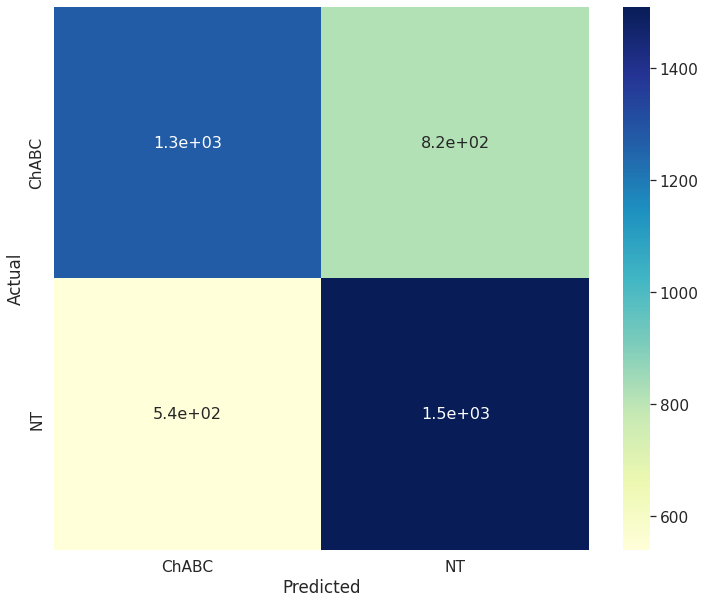

In [35]:
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [36]:
# Needed bc of this issue: https://github.com/slundberg/shap/issues/1215

model_bytearray = booster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

booster.save_raw = myfun

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test[features])

In [38]:
shap_values

[array([[ 0.00281517,  0.07687426, -0.01404278, ...,  0.02442584,
          0.6107337 ,  0.26532376],
        [ 0.00186809,  0.05185002, -0.01745249, ..., -0.01967879,
         -0.03491734,  0.01486971],
        [-0.01920062, -0.03352578, -0.01126304, ...,  0.01783509,
         -0.07513607,  0.04747902],
        ...,
        [ 0.00117088,  0.05160744,  0.01226285, ..., -0.02203618,
          0.04640811, -0.09195825],
        [-0.00201516, -0.00621592, -0.01721488, ...,  0.02128366,
          0.4362146 , -0.00239869],
        [-0.00994106, -0.02069058,  0.02825637, ..., -0.01917967,
         -0.09374865, -0.00095862]], dtype=float32),
 array([[-0.03348584, -0.14996994,  0.01544118, ..., -0.00339903,
         -0.57190394, -0.20282412],
        [ 0.02159046, -0.0770034 ,  0.01660485, ...,  0.0193559 ,
          0.08050187, -0.01458864],
        [-0.01713615,  0.09067735,  0.02131414, ..., -0.01215054,
          0.101692  , -0.06414065],
        ...,
        [ 0.01731131, -0.1066214 , -0.0264273 , ...,  0.02269875,
         -0.01128286,  0.11264018],
        [-0.04533958,  0.031314  ,  0.02448769, ..., -0.0269876 ,
         -0.39599898, -0.06987604],
        [ 0.01302896,  0.0489072 , -0.02502365, ...,  0.03119454,
          0.11342312, -0.00183903]], dtype=float32)]

In [39]:
c_NT = '#E69F00'
#c_HYase = '#56B4E9'
c_ChABC = '#009E73'

colors = [c_NT, c_ChABC]
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

In [40]:
class_inds

array([0, 1])

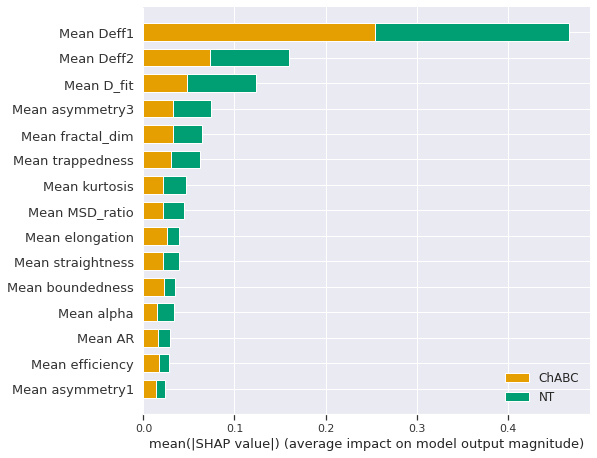

In [41]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), max_display=15, title='Total SHAP Values', color=cmap)

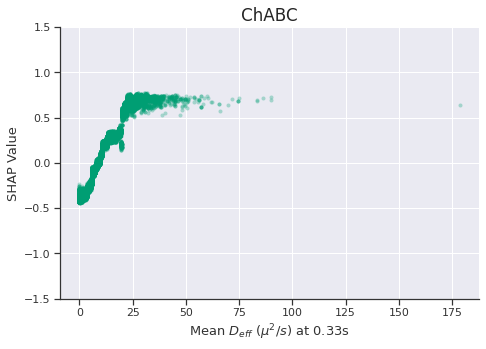

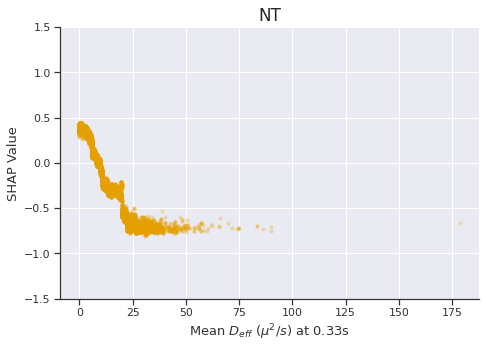

In [160]:
plt.ioff()
%matplotlib inline

figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean Deff1", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.3, ax=ax, show=False)
    ax.set_xlabel(r'Mean $D_{eff}$ ($\mu^2/s$) at 0.33s')
    ax.set_ylabel('SHAP Value')
    ax.set_title(class_names[i])

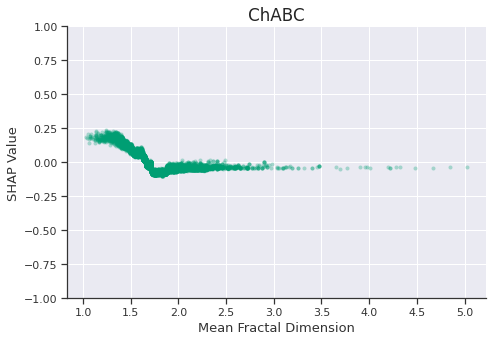

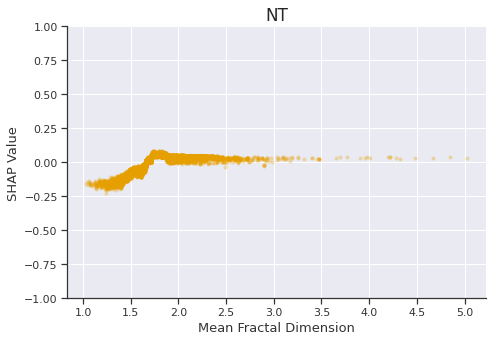

In [161]:
figsize = (7.5, 5)
bottom = -1
top = 1
for i in range(len(shap_values)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean fractal_dim", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.3, ax=ax, show=False)
    ax.set_xlabel('Mean Fractal Dimension')
    ax.set_ylabel('SHAP Value')
    ax.set_title(class_names[i])

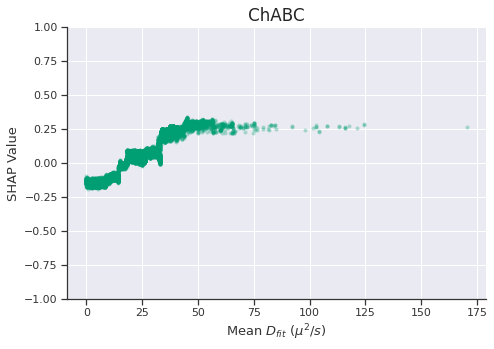

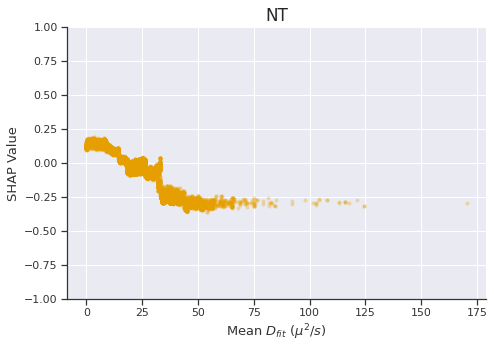

In [162]:
figsize = (7.5, 5)
bottom = -1
top = 1
for i in range(len(shap_values)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean D_fit", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.3, ax=ax, show=False)
    ax.set_xlabel(r'Mean $D_{fit}$ ($\mu^2/s$)')
    ax.set_ylabel('SHAP Value')
    ax.set_title(class_names[i])

Text(0.5, 1.0, 'Top 5 Features for NT')

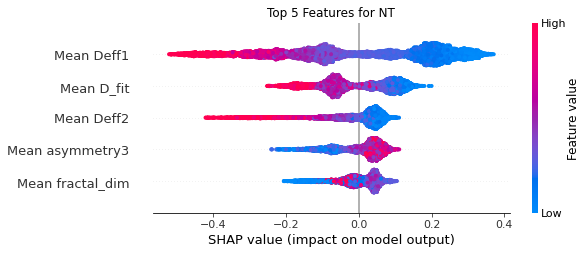

In [46]:
figsize = (7.5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.gca()
shap.summary_plot(shap_values[1], X_test[features], max_display=5, class_names = class_names, title = 'SHAP Value for P14', show=False)
ax.set_title('Top 5 Features for NT')

Here, we are going to try and average the files before putting them into a model


In [4]:
columns = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    #'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    #'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    'Mean alpha',
    'Mean D_fit',
    'Mean kurtosis',
    'Mean asymmetry1',
    'Mean asymmetry2',
    'Mean asymmetry3',
    #'Mean AR',
    'Mean elongation',
    'Mean boundedness',
    'Mean fractal_dim',
    'Mean trappedness',
    'Mean efficiency',
    'Mean straightness',
    'Mean MSD_ratio',
    'Mean Deff1',
    'Mean Deff2',
    #'X',
    #'Y',
    #'Treatment'
]

target = 'Target'

In [5]:
chabc_filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f)) and 'ChABC' in f]
nt_filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f)) and 'NT' in f]

brain_splits = [15, 30, 45, 60]

In [6]:
df = pd.read_csv(dataset_path + filelist[0])

In [7]:
def generate_mean_df(filelist, dataset_path, columns):
    all_data = []
    for file in filelist:
        df = pd.read_csv(dataset_path + file)
        data = []
        for col in columns:
            val = df[col].mean(axis=0)
            data.append(val)
        all_data.append(data)
    output_df = pd.DataFrame(all_data, columns=columns)
    output_df = output_df[~output_df[list(set(columns) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)] 
    return output_df

In [8]:
chabc_train_df = generate_mean_df(chabc_filelist[0:30], dataset_path, columns)
chabc_train_df['Target'] = 1

chabc_val_df = generate_mean_df(chabc_filelist[30:45], dataset_path, columns)
chabc_val_df['Target'] = 1

chabc_test_df = generate_mean_df(chabc_filelist[45:60], dataset_path, columns)
chabc_test_df['Target'] = 1

In [9]:
nt_train_df = generate_mean_df(nt_filelist[0:30], dataset_path, columns)
nt_train_df['Target'] = 0

nt_val_df = generate_mean_df(nt_filelist[30:45], dataset_path, columns)
nt_val_df['Target'] = 0

nt_test_df = generate_mean_df(nt_filelist[45:60], dataset_path, columns)
nt_test_df['Target'] = 0

In [10]:
train_df = pd.concat([chabc_train_df, nt_train_df])
test_df = pd.concat([chabc_test_df, nt_test_df])
val_df = pd.concat([chabc_val_df, nt_val_df])

In [11]:
dtrain = xgb.DMatrix(train_df[columns], label=train_df[target])
dtest = xgb.DMatrix(test_df[columns], label=test_df[target])
dval = xgb.DMatrix(val_df[columns], label=val_df[target])

In [12]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 2,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
         #GPU integration will cut time in ~half:
         'gpu_id' : 0,
         'tree_method': 'gpu_hist',
         'predictor': 'gpu_predictor'
         }

In [21]:
def train(param, dtrain, dtest, dval=None, evals=[(dtrain, 'train')], num_round=40):
    if dval is not None and (dval, 'eval') not in evals:
        evals += [(dval, 'eval')]
    model = xgb.train(param, dtrain, num_round, evals, )
    true_label = dtest.get_label()
    ypred = model.predict(dtest)
    preds = [np.where(x == np.max(x))[0][0] for x in ypred]
    acc = metrics.accuracy_score(true_label, preds)
    print("Accuracy:",acc)
    return model, acc, true_label, preds
booster, acc, true_label, preds = train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=2000)

[0]	train-mlogloss:0.69313	eval-mlogloss:0.69302
[1]	train-mlogloss:0.69311	eval-mlogloss:0.69291
[2]	train-mlogloss:0.69313	eval-mlogloss:0.69302
[3]	train-mlogloss:0.69311	eval-mlogloss:0.69291
[4]	train-mlogloss:0.69310	eval-mlogloss:0.69285
[5]	train-mlogloss:0.69310	eval-mlogloss:0.69284
[6]	train-mlogloss:0.69308	eval-mlogloss:0.69271
[7]	train-mlogloss:0.69308	eval-mlogloss:0.69272
[8]	train-mlogloss:0.69307	eval-mlogloss:0.69263
[9]	train-mlogloss:0.69306	eval-mlogloss:0.69259
[10]	train-mlogloss:0.69306	eval-mlogloss:0.69259
[11]	train-mlogloss:0.69305	eval-mlogloss:0.69249
[12]	train-mlogloss:0.69304	eval-mlogloss:0.69245
[13]	train-mlogloss:0.69303	eval-mlogloss:0.69237
[14]	train-mlogloss:0.69302	eval-mlogloss:0.69229
[15]	train-mlogloss:0.69302	eval-mlogloss:0.69229
[16]	train-mlogloss:0.69302	eval-mlogloss:0.69228
[17]	train-mlogloss:0.69302	eval-mlogloss:0.69229
[18]	train-mlogloss:0.69301	eval-mlogloss:0.69224
[19]	train-mlogloss:0.69302	eval-mlogloss:0.69231
[20]	train

[163]	train-mlogloss:0.69303	eval-mlogloss:0.69234
[164]	train-mlogloss:0.69302	eval-mlogloss:0.69232
[165]	train-mlogloss:0.69303	eval-mlogloss:0.69235
[166]	train-mlogloss:0.69303	eval-mlogloss:0.69240
[167]	train-mlogloss:0.69303	eval-mlogloss:0.69240
[168]	train-mlogloss:0.69305	eval-mlogloss:0.69250
[169]	train-mlogloss:0.69304	eval-mlogloss:0.69245
[170]	train-mlogloss:0.69302	eval-mlogloss:0.69232
[171]	train-mlogloss:0.69303	eval-mlogloss:0.69237
[172]	train-mlogloss:0.69301	eval-mlogloss:0.69224
[173]	train-mlogloss:0.69302	eval-mlogloss:0.69232
[174]	train-mlogloss:0.69302	eval-mlogloss:0.69225
[175]	train-mlogloss:0.69304	eval-mlogloss:0.69244
[176]	train-mlogloss:0.69304	eval-mlogloss:0.69246
[177]	train-mlogloss:0.69304	eval-mlogloss:0.69243
[178]	train-mlogloss:0.69306	eval-mlogloss:0.69257
[179]	train-mlogloss:0.69307	eval-mlogloss:0.69266
[180]	train-mlogloss:0.69306	eval-mlogloss:0.69262
[181]	train-mlogloss:0.69306	eval-mlogloss:0.69262
[182]	train-mlogloss:0.69306	ev

[324]	train-mlogloss:0.69127	eval-mlogloss:0.69004
[325]	train-mlogloss:0.69127	eval-mlogloss:0.69018
[326]	train-mlogloss:0.69127	eval-mlogloss:0.69012
[327]	train-mlogloss:0.69127	eval-mlogloss:0.69017
[328]	train-mlogloss:0.69127	eval-mlogloss:0.69025
[329]	train-mlogloss:0.69127	eval-mlogloss:0.69019
[330]	train-mlogloss:0.69126	eval-mlogloss:0.69030
[331]	train-mlogloss:0.69126	eval-mlogloss:0.69042
[332]	train-mlogloss:0.69126	eval-mlogloss:0.69036
[333]	train-mlogloss:0.69126	eval-mlogloss:0.69038
[334]	train-mlogloss:0.69126	eval-mlogloss:0.69028
[335]	train-mlogloss:0.69126	eval-mlogloss:0.69031
[336]	train-mlogloss:0.69126	eval-mlogloss:0.69029
[337]	train-mlogloss:0.69126	eval-mlogloss:0.69041
[338]	train-mlogloss:0.69126	eval-mlogloss:0.69035
[339]	train-mlogloss:0.69127	eval-mlogloss:0.69055
[340]	train-mlogloss:0.69127	eval-mlogloss:0.69051
[341]	train-mlogloss:0.69127	eval-mlogloss:0.69054
[342]	train-mlogloss:0.69126	eval-mlogloss:0.69047
[343]	train-mlogloss:0.69126	ev

[485]	train-mlogloss:0.69153	eval-mlogloss:0.69317
[486]	train-mlogloss:0.69151	eval-mlogloss:0.69308
[487]	train-mlogloss:0.69154	eval-mlogloss:0.69326
[488]	train-mlogloss:0.69159	eval-mlogloss:0.69349
[489]	train-mlogloss:0.69157	eval-mlogloss:0.69341
[490]	train-mlogloss:0.69154	eval-mlogloss:0.69326
[491]	train-mlogloss:0.69154	eval-mlogloss:0.69326
[492]	train-mlogloss:0.69155	eval-mlogloss:0.69327
[493]	train-mlogloss:0.69154	eval-mlogloss:0.69322
[494]	train-mlogloss:0.69153	eval-mlogloss:0.69320
[495]	train-mlogloss:0.69149	eval-mlogloss:0.69297
[496]	train-mlogloss:0.69147	eval-mlogloss:0.69284
[497]	train-mlogloss:0.69149	eval-mlogloss:0.69294
[498]	train-mlogloss:0.69148	eval-mlogloss:0.69289
[499]	train-mlogloss:0.69144	eval-mlogloss:0.69265
[500]	train-mlogloss:0.69144	eval-mlogloss:0.69265
[501]	train-mlogloss:0.69146	eval-mlogloss:0.69276
[502]	train-mlogloss:0.69145	eval-mlogloss:0.69271
[503]	train-mlogloss:0.69145	eval-mlogloss:0.69266
[504]	train-mlogloss:0.69143	ev

[646]	train-mlogloss:0.68956	eval-mlogloss:0.68969
[647]	train-mlogloss:0.68957	eval-mlogloss:0.68965
[648]	train-mlogloss:0.68958	eval-mlogloss:0.68952
[649]	train-mlogloss:0.68957	eval-mlogloss:0.68960
[650]	train-mlogloss:0.68959	eval-mlogloss:0.68944
[651]	train-mlogloss:0.68960	eval-mlogloss:0.68928
[652]	train-mlogloss:0.68963	eval-mlogloss:0.68903
[653]	train-mlogloss:0.68963	eval-mlogloss:0.68900
[654]	train-mlogloss:0.68962	eval-mlogloss:0.68909
[655]	train-mlogloss:0.68962	eval-mlogloss:0.68912
[656]	train-mlogloss:0.68961	eval-mlogloss:0.68915
[657]	train-mlogloss:0.68963	eval-mlogloss:0.68901
[658]	train-mlogloss:0.68963	eval-mlogloss:0.68902
[659]	train-mlogloss:0.68963	eval-mlogloss:0.68906
[660]	train-mlogloss:0.68963	eval-mlogloss:0.68902
[661]	train-mlogloss:0.68963	eval-mlogloss:0.68903
[662]	train-mlogloss:0.68829	eval-mlogloss:0.68925
[663]	train-mlogloss:0.68828	eval-mlogloss:0.68928
[664]	train-mlogloss:0.68829	eval-mlogloss:0.68924
[665]	train-mlogloss:0.68828	ev

[807]	train-mlogloss:0.68673	eval-mlogloss:0.69000
[808]	train-mlogloss:0.68673	eval-mlogloss:0.68999
[809]	train-mlogloss:0.68673	eval-mlogloss:0.68998
[810]	train-mlogloss:0.68673	eval-mlogloss:0.69002
[811]	train-mlogloss:0.68673	eval-mlogloss:0.68994
[812]	train-mlogloss:0.68673	eval-mlogloss:0.68995
[813]	train-mlogloss:0.68674	eval-mlogloss:0.68990
[814]	train-mlogloss:0.68673	eval-mlogloss:0.68999
[815]	train-mlogloss:0.68673	eval-mlogloss:0.69003
[816]	train-mlogloss:0.68673	eval-mlogloss:0.69022
[817]	train-mlogloss:0.68673	eval-mlogloss:0.69017
[818]	train-mlogloss:0.68673	eval-mlogloss:0.69019
[819]	train-mlogloss:0.68672	eval-mlogloss:0.69029
[820]	train-mlogloss:0.68672	eval-mlogloss:0.69030
[821]	train-mlogloss:0.68673	eval-mlogloss:0.69010
[822]	train-mlogloss:0.68673	eval-mlogloss:0.69013
[823]	train-mlogloss:0.68673	eval-mlogloss:0.69021
[824]	train-mlogloss:0.68672	eval-mlogloss:0.69024
[825]	train-mlogloss:0.68673	eval-mlogloss:0.69022
[826]	train-mlogloss:0.68672	ev

[968]	train-mlogloss:0.68672	eval-mlogloss:0.69058
[969]	train-mlogloss:0.68672	eval-mlogloss:0.69071
[970]	train-mlogloss:0.68672	eval-mlogloss:0.69059
[971]	train-mlogloss:0.68672	eval-mlogloss:0.69072
[972]	train-mlogloss:0.68673	eval-mlogloss:0.69082
[973]	train-mlogloss:0.68673	eval-mlogloss:0.69097
[974]	train-mlogloss:0.68672	eval-mlogloss:0.69076
[975]	train-mlogloss:0.68673	eval-mlogloss:0.69082
[976]	train-mlogloss:0.68673	eval-mlogloss:0.69089
[977]	train-mlogloss:0.68672	eval-mlogloss:0.69062
[978]	train-mlogloss:0.68672	eval-mlogloss:0.69056
[979]	train-mlogloss:0.68672	eval-mlogloss:0.69048
[980]	train-mlogloss:0.68672	eval-mlogloss:0.69037
[981]	train-mlogloss:0.68672	eval-mlogloss:0.69044
[982]	train-mlogloss:0.68672	eval-mlogloss:0.69030
[983]	train-mlogloss:0.68672	eval-mlogloss:0.69023
[984]	train-mlogloss:0.68672	eval-mlogloss:0.69031
[985]	train-mlogloss:0.68672	eval-mlogloss:0.69024
[986]	train-mlogloss:0.68673	eval-mlogloss:0.69015
[987]	train-mlogloss:0.68673	ev

[1127]	train-mlogloss:0.68681	eval-mlogloss:0.68906
[1128]	train-mlogloss:0.68681	eval-mlogloss:0.68912
[1129]	train-mlogloss:0.68680	eval-mlogloss:0.68916
[1130]	train-mlogloss:0.68680	eval-mlogloss:0.68915
[1131]	train-mlogloss:0.68681	eval-mlogloss:0.68911
[1132]	train-mlogloss:0.68681	eval-mlogloss:0.68906
[1133]	train-mlogloss:0.68681	eval-mlogloss:0.68907
[1134]	train-mlogloss:0.68681	eval-mlogloss:0.68907
[1135]	train-mlogloss:0.68683	eval-mlogloss:0.68893
[1136]	train-mlogloss:0.68683	eval-mlogloss:0.68897
[1137]	train-mlogloss:0.68682	eval-mlogloss:0.68898
[1138]	train-mlogloss:0.68682	eval-mlogloss:0.68900
[1139]	train-mlogloss:0.68683	eval-mlogloss:0.68897
[1140]	train-mlogloss:0.68681	eval-mlogloss:0.68906
[1141]	train-mlogloss:0.68683	eval-mlogloss:0.68897
[1142]	train-mlogloss:0.68683	eval-mlogloss:0.68894
[1143]	train-mlogloss:0.68681	eval-mlogloss:0.68909
[1144]	train-mlogloss:0.68681	eval-mlogloss:0.68908
[1145]	train-mlogloss:0.68680	eval-mlogloss:0.68915
[1146]	train

[1285]	train-mlogloss:0.68673	eval-mlogloss:0.69002
[1286]	train-mlogloss:0.68673	eval-mlogloss:0.69003
[1287]	train-mlogloss:0.68673	eval-mlogloss:0.69002
[1288]	train-mlogloss:0.68673	eval-mlogloss:0.69006
[1289]	train-mlogloss:0.68673	eval-mlogloss:0.68995
[1290]	train-mlogloss:0.68674	eval-mlogloss:0.68991
[1291]	train-mlogloss:0.68674	eval-mlogloss:0.68985
[1292]	train-mlogloss:0.68674	eval-mlogloss:0.68979
[1293]	train-mlogloss:0.68673	eval-mlogloss:0.68993
[1294]	train-mlogloss:0.68673	eval-mlogloss:0.69014
[1295]	train-mlogloss:0.68673	eval-mlogloss:0.69019
[1296]	train-mlogloss:0.68672	eval-mlogloss:0.69030
[1297]	train-mlogloss:0.68672	eval-mlogloss:0.69045
[1298]	train-mlogloss:0.68672	eval-mlogloss:0.69049
[1299]	train-mlogloss:0.68672	eval-mlogloss:0.69063
[1300]	train-mlogloss:0.68672	eval-mlogloss:0.69053
[1301]	train-mlogloss:0.68672	eval-mlogloss:0.69034
[1302]	train-mlogloss:0.68672	eval-mlogloss:0.69024
[1303]	train-mlogloss:0.68673	eval-mlogloss:0.69013
[1304]	train

[1443]	train-mlogloss:0.68520	eval-mlogloss:0.68920
[1444]	train-mlogloss:0.68518	eval-mlogloss:0.68933
[1445]	train-mlogloss:0.68519	eval-mlogloss:0.68926
[1446]	train-mlogloss:0.68521	eval-mlogloss:0.68908
[1447]	train-mlogloss:0.68522	eval-mlogloss:0.68907
[1448]	train-mlogloss:0.68520	eval-mlogloss:0.68916
[1449]	train-mlogloss:0.68519	eval-mlogloss:0.68925
[1450]	train-mlogloss:0.68518	eval-mlogloss:0.68937
[1451]	train-mlogloss:0.68518	eval-mlogloss:0.68935
[1452]	train-mlogloss:0.68519	eval-mlogloss:0.68926
[1453]	train-mlogloss:0.68519	eval-mlogloss:0.68926
[1454]	train-mlogloss:0.68517	eval-mlogloss:0.68944
[1455]	train-mlogloss:0.68517	eval-mlogloss:0.68948
[1456]	train-mlogloss:0.68518	eval-mlogloss:0.68938
[1457]	train-mlogloss:0.68519	eval-mlogloss:0.68929
[1458]	train-mlogloss:0.68518	eval-mlogloss:0.68936
[1459]	train-mlogloss:0.68517	eval-mlogloss:0.68942
[1460]	train-mlogloss:0.68382	eval-mlogloss:0.68892
[1461]	train-mlogloss:0.68381	eval-mlogloss:0.68897
[1462]	train

[1601]	train-mlogloss:0.68377	eval-mlogloss:0.69038
[1602]	train-mlogloss:0.68377	eval-mlogloss:0.69038
[1603]	train-mlogloss:0.68377	eval-mlogloss:0.69030
[1604]	train-mlogloss:0.68377	eval-mlogloss:0.69037
[1605]	train-mlogloss:0.68377	eval-mlogloss:0.69030
[1606]	train-mlogloss:0.68377	eval-mlogloss:0.69038
[1607]	train-mlogloss:0.68377	eval-mlogloss:0.69033
[1608]	train-mlogloss:0.68377	eval-mlogloss:0.69016
[1609]	train-mlogloss:0.68377	eval-mlogloss:0.69020
[1610]	train-mlogloss:0.68377	eval-mlogloss:0.69036
[1611]	train-mlogloss:0.68377	eval-mlogloss:0.69032
[1612]	train-mlogloss:0.68377	eval-mlogloss:0.69024
[1613]	train-mlogloss:0.68377	eval-mlogloss:0.69027
[1614]	train-mlogloss:0.68377	eval-mlogloss:0.69039
[1615]	train-mlogloss:0.68377	eval-mlogloss:0.69043
[1616]	train-mlogloss:0.68377	eval-mlogloss:0.69042
[1617]	train-mlogloss:0.68378	eval-mlogloss:0.69047
[1618]	train-mlogloss:0.68378	eval-mlogloss:0.69059
[1619]	train-mlogloss:0.68378	eval-mlogloss:0.69066
[1620]	train

[1759]	train-mlogloss:0.68377	eval-mlogloss:0.68977
[1760]	train-mlogloss:0.68377	eval-mlogloss:0.68983
[1761]	train-mlogloss:0.68377	eval-mlogloss:0.68969
[1762]	train-mlogloss:0.68377	eval-mlogloss:0.68977
[1763]	train-mlogloss:0.68377	eval-mlogloss:0.68999
[1764]	train-mlogloss:0.68377	eval-mlogloss:0.68995
[1765]	train-mlogloss:0.68377	eval-mlogloss:0.68998
[1766]	train-mlogloss:0.68377	eval-mlogloss:0.69000
[1767]	train-mlogloss:0.68377	eval-mlogloss:0.69000
[1768]	train-mlogloss:0.68377	eval-mlogloss:0.69010
[1769]	train-mlogloss:0.68377	eval-mlogloss:0.69016
[1770]	train-mlogloss:0.68377	eval-mlogloss:0.69026
[1771]	train-mlogloss:0.68377	eval-mlogloss:0.69019
[1772]	train-mlogloss:0.68377	eval-mlogloss:0.69028
[1773]	train-mlogloss:0.68377	eval-mlogloss:0.69022
[1774]	train-mlogloss:0.68377	eval-mlogloss:0.69019
[1775]	train-mlogloss:0.68377	eval-mlogloss:0.69017
[1776]	train-mlogloss:0.68377	eval-mlogloss:0.69029
[1777]	train-mlogloss:0.68377	eval-mlogloss:0.69021
[1778]	train

[1917]	train-mlogloss:0.68386	eval-mlogloss:0.68856
[1918]	train-mlogloss:0.68387	eval-mlogloss:0.68845
[1919]	train-mlogloss:0.68387	eval-mlogloss:0.68847
[1920]	train-mlogloss:0.68385	eval-mlogloss:0.68860
[1921]	train-mlogloss:0.68382	eval-mlogloss:0.68888
[1922]	train-mlogloss:0.68382	eval-mlogloss:0.68891
[1923]	train-mlogloss:0.68382	eval-mlogloss:0.68893
[1924]	train-mlogloss:0.68385	eval-mlogloss:0.68865
[1925]	train-mlogloss:0.68385	eval-mlogloss:0.68861
[1926]	train-mlogloss:0.68387	eval-mlogloss:0.68849
[1927]	train-mlogloss:0.68388	eval-mlogloss:0.68840
[1928]	train-mlogloss:0.68388	eval-mlogloss:0.68841
[1929]	train-mlogloss:0.68390	eval-mlogloss:0.68827
[1930]	train-mlogloss:0.68391	eval-mlogloss:0.68824
[1931]	train-mlogloss:0.68392	eval-mlogloss:0.68819
[1932]	train-mlogloss:0.68394	eval-mlogloss:0.68803
[1933]	train-mlogloss:0.68397	eval-mlogloss:0.68791
[1934]	train-mlogloss:0.68396	eval-mlogloss:0.68794
[1935]	train-mlogloss:0.68398	eval-mlogloss:0.68786
[1936]	train